# RNA-DNAm: scBOND

The following tutorial demonstrate how to use scBOND model making translation between scRNA-seq and scDNAm profiles.

There are three parts of this tutorial:

**(1) Read in data and load it to scBOND.** This part will tell you how to load and pre-process scRNA-seq and scDNAm profiles data for scBOND model.

**(2) Construct a scBOND model.** This part will tell you how to generate and train a scBOND model.

**(3) Get prediction and evaluate the performance.** This part will tell you how to get prediction from scBOND model and evaluate the performance of prediction.

## Read in data and load it to scBOND

scBOND has integrated the process of pre-processing, constructing model, training model and evaluating in scBOND.bond for paired scRNA-seq and scDNAm profiles. You could easily use it as follow:

In [1]:
import scBond
from scBond.bond import Bond
import scanpy as sc

In [2]:
bond = Bond()

Here we use [**the HumanBrainA dataset**](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE140493), which was generated using the snmCAT-seq protocol. It comprises 4013 nuclei isolated from postmortem human frontal cortex. (Luo, C., et al., 2023)

In [3]:
RNA_data = sc.read_h5ad('adata_rna.h5ad')
MET_data = sc.read_h5ad('adata_met.h5ad')

In [4]:
all_indices = MET_data.var.index.tolist()
MET_data.var['chrom'] = [idx[:4] if len(idx) >= 4 else idx for idx in all_indices]
MET_data.obs['cell_type'] = MET_data.obs['MajorType']
RNA_data.obs['cell_type'] = RNA_data.obs['MajorType']

We provide data split settings in scBOND.split_dataset for reproducibility. You could use parameters train_id, validation_id and test_id customize your own datasets splitting settings.

In [5]:
from scBond.split_datasets import *

In [6]:
id_list = five_fold_split_dataset(RNA_data, MET_data)
train_id, validation_id, test_id = id_list[0]

Then we load data into scBOND.

In [7]:
bond.load_data(RNA_data, MET_data, train_id, test_id, validation_id)

[INFO] Bond: successfully load in data with

RNA data:
AnnData object with n_obs × n_vars = 4013 × 60606
    obs: 'fig2_tsne_0', 'fig2_tsne_1', 'fig2_umap_0', 'fig2_umap_1', 'MajorType', 'SubType', 'cell_type'

MET data:
AnnData object with n_obs × n_vars = 4013 × 309556
    obs: 'fig2_tsne_0', 'fig2_tsne_1', 'fig2_umap_0', 'fig2_umap_1', 'MajorType', 'SubType', 'cell_type'
    var: 'chrom'


scBOND could pre-process data Automatically, custom settings is also provided.

In [8]:
bond.data_preprocessing()

[INFO] RNA preprocessing: normalize size factor.
[INFO] RNA preprocessing: log transform RNA data.
[INFO] RNA preprocessing: choose top 3000 genes for following training.
[INFO] MET preprocessing: Filtering features: min 29.0 cells (0.700%) per feature
[INFO] MET preprocessing: Performing missing value imputation using method: median
[INFO] MET preprocessing: Performing min-max scaling.


## Construct a scBOND model

We use no data augmentation strategy here, for more information, see in scBOND-Aug.

In [9]:
bond.augmentation(aug_type=None)
#bond.augmentation(enable_augmentation=False)

scBOND model needs the information of peaks chromosomes, we should sort the scDNAm profiles data with chromosomes and tell scBOND the count of peaks in each chromosome.

In [10]:
chrom_list = []
last_one = ''
for i in range(len(bond.MET_data_p.var.chrom)):
    temp = bond.MET_data_p.var.chrom[i]
    if temp[0 : 3] == 'chr':
        if not temp == last_one:
            chrom_list.append(1)
            last_one = temp
        else:
            chrom_list[-1] += 1
    else:
        chrom_list[-1] += 1
        
print(chrom_list, end="")

[22471, 23784, 19482, 18767, 17739, 16740, 15537, 14281, 11873, 94526, 12268, 14783, 2012, 1]

In [11]:
sum(chrom_list)

284264

We construct and train scBOND model with default settings.

In [12]:
bond.construct_model(chrom_list=chrom_list)

[INFO] Bond: successfully construct bond model.


In [13]:
bond.train_model()

[INFO] Bond: training bond model ...
[INFO] Trainer: MET pretraining ...
MET pretrain: 100%|█████████████████████| 100/100 [18:38<00:00, 11.18s/it, train=0.2820, val=0.2780]
[INFO] Trainer: RNA pretraining ...
RNA pretrain: 100%|█████████████████████| 100/100 [11:48<00:00,  7.08s/it, train=0.2657, val=0.2753]
[INFO] Trainer: Integrative training ...
Integrative training: 100%|█████████████| 200/200 [31:29<00:00,  9.45s/it, train=1.6347, val=1.5989]


## Get prediction and evaluate the performance

You could get cross-modal predictions using bond.test_model with default settings. We also provided more information metrics in this function, see in API.

In [14]:
M2R_predict, R2M_predict = bond.test_model()

[INFO] Bond: testing bond model ...
[INFO] Tester: get predicting ...
MET to RNA predicting...: 100%|█████████████████████████████████████| 13/13 [00:02<00:00,  6.05it/s]
[INFO] Tester: calculate neighbors graph for following test ...


Here we draw the UMAP embeddings and measure the ARI, AMI, NMI, and HOM.

In [15]:
from scBond.calculate_cluster import calculate_cluster_index

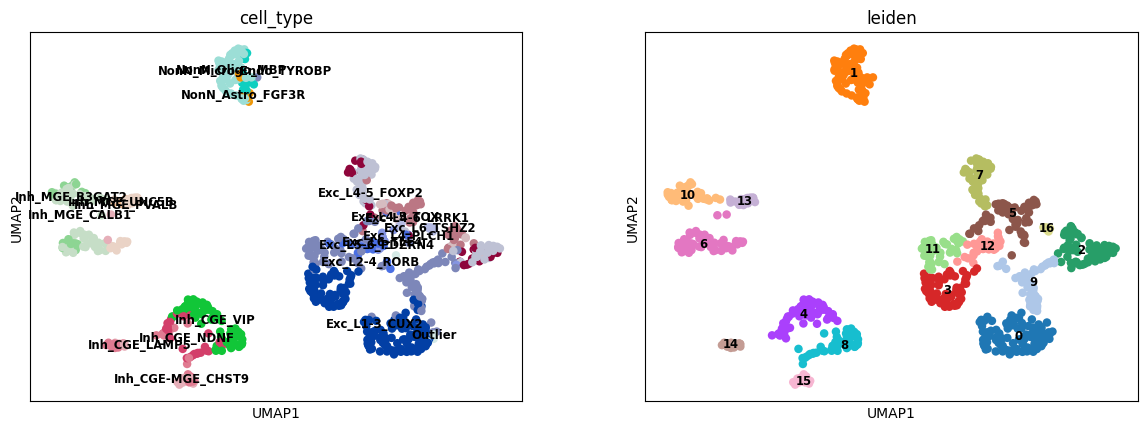

In [16]:
sc.tl.umap(M2R_predict)
sc.tl.leiden(M2R_predict)
sc.pl.umap(M2R_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [17]:
ARI, AMI, NMI, HOM = calculate_cluster_index(M2R_predict)
print('DNAm to RNA:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

DNAm to RNA:
ARI: 0.484, 	AMI: 0.678, 	NMI: 0.703, 	HOM: 0.709


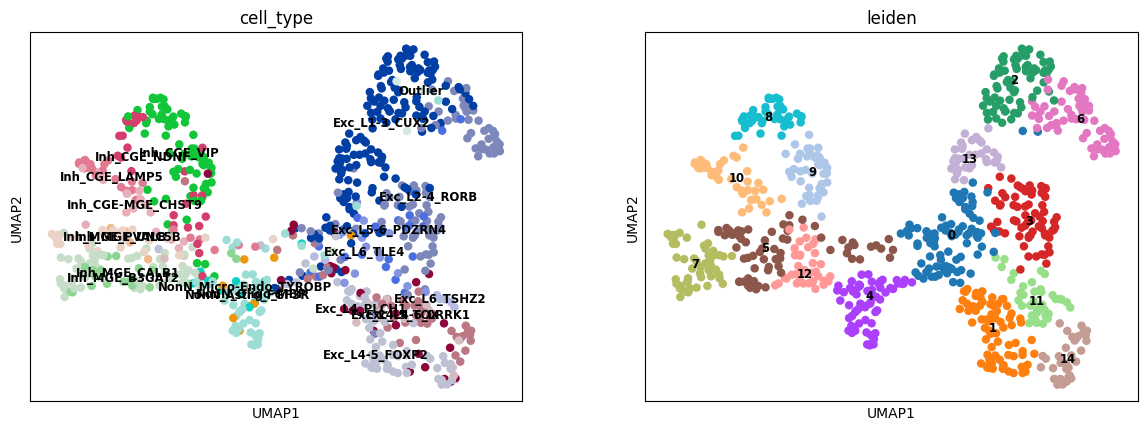

In [18]:
sc.tl.umap(R2M_predict)
sc.tl.leiden(R2M_predict)
sc.pl.umap(R2M_predict, color=['cell_type', 'leiden'], legend_loc='on data', legend_fontsize='small')

In [19]:
ARI, AMI, NMI, HOM = calculate_cluster_index(R2M_predict)
print('RNA to DNAm:\nARI: %.3f, \tAMI: %.3f, \tNMI: %.3f, \tHOM: %.3f' % (ARI, AMI, NMI, HOM))

RNA to DNAm:
ARI: 0.324, 	AMI: 0.525, 	NMI: 0.559, 	HOM: 0.560
